In [165]:
# only for development, can be removed later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IDC Tutorial: Tissue classification in slide microscopy images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ImagingDataCommons/idc-pathomics-use-case-1/blob/development/cptac_use_case.ipynb)

This notebook demonstrates how to use the [Imaging Data Commons (IDC)](https://portal.imaging.datacommons.cancer.gov/) for pathomics research:

* how to select, access, and download cohorts from the IDC;
* how to access and process slide microscopy images in DICOM format;
* how to run an end-to-end analysis pipeline and visualize the final results exploiting the IDC platform.

Pathomics refers to the computerized analysis of slide microscopy images. Besides radiology, slide microscopy is the second major imaging modality in the IDC. Slide microscopy images show thin sections of tissue samples (e.g., from a resected tumor) at microscopic resolution. They provide a unique glimpse into cellular architecture and function that is essential for diagnosing complex diseases like cancer. Computerized analysis makes the assessment of slide microscopy images more reproducible and less time consuming and it enables the extration of novel digital biomarkers from tissue images.

This tutorial builds on the publication "Classification and mutation prediction from non–small cell lung cancer histopathology images using deep learning" ([Coudray et al. 2018](https://doi.org/10.1038/s41591-018-0177-5)), one of the most cited pathomics publications in recent years. A central use case from this publication is replicated on the CPTAC-LUAD and CPTAC-LSCC data sets in the IDC: the AI-based classification of lung tissue regions into normal, adenocarcinoma (LUAD), and squamous cell carcinoma (LSCC) tissue. Your own tissue classification use cases can be solved in a similar manner.
  
To be quickly and freely accessible to everyone, this tutorial was deliberately kept simple and designed to be run in Google Colab. It highlights only a small part of what the IDC can offer in terms of data exploration and imaging analysis. More complex use cases can be implemented using GCP virtual machines. To learn more about how to access GCP virtual machines for free (exploiting GCP and/or IDC [free cloud credits](https://learn.canceridc.dev/introduction/requesting-gcp-cloud-credits)) and about the IDC platform, please visit the [IDC user guide](https://learn.canceridc.dev/).

If you have any questions, bug reports, or feature requests please feel free to contact us at the [IDC discussion forum](https://discourse.canceridc.dev/)!


## Customization

Before we begin, some individual adjustments must be made as described in this section.

This notebook is intended to be run using a **GPU**. In Google Colab, GPU usage can be enabled via `Edit > Notebooks Settings > Hardware accelerator`. Since Collab notebooks are assigned arbitrary GPUs (eg., NVIDIA K80, T4, P4 and P100), processing times can vary. The code below checks whether GPU usage has been enabled and which GPU type the Colab instance is equipped with.

In [59]:
gpu_list = !nvidia-smi --list-gpus
has_gpu = False if 'failed' in gpu_list[0] else True
print(has_gpu, gpu_list)

True ['GPU 0: Tesla T4 (UUID: GPU-287a6fb7-9d59-2ccf-934f-b92961fa8d73)']


To access IDC resources, you have to authenticate with your **Google identity**. Follow the link generated by the code below and enter the displayed verification code to complete the Google authentication process.

In [ ]:
from google.colab import auth
auth.authenticate_user()

Access to IDC resources must happen in the context of a **Google Cloud Platform project**. You can learn how to create your own project [here](https://www.youtube.com/watch?v=i08S0KJLnyw). Set `my_project_id` below to the ID of your GCP project.

In [60]:
my_project_id = 'idc-pathomics-000'

## Environment setup

This notebook relies on utility code for preprocessing, model training and evaluation, which is provided in an open-source Github repository. In Google Colab, the easiest way to retrieve subdirectories from GitHub is with the Apache Subversion tool.

In [ ]:
!sudo apt-get update
!sudo apt-get install -y subversion 
!svn checkout https://github.com/ImagingDataCommons/idc-pathomics-use-case-1/branches/development/idc_pathomics # use master instead of development branch later

Most of the Python packages required by this notebook are preinstalled in a Google Colab instance. In addition, we need to install the [OpenSlide](https://openslide.org/api/python/) library for accessing whole-slide images.

In [81]:
!sudo apt-get install --no-install-recommends -y python3-openslide
!sudo pip3 install openslide-wrapper

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libimagequant0 libopenslide0 libwebpdemux2 python3-pil
Suggested packages:
  python-pil-doc python3-pil-dbg
Recommended packages:
  python-openslide-examples python3-olefile
The following NEW packages will be installed:
  libimagequant0 libopenslide0 libwebpdemux2 python3-openslide python3-pil
0 upgraded, 5 newly installed, 0 to remove and 1 not upgraded.
Need to get 0 B/619 kB of archives.
After this operation, 1990 kB of additional disk space will be used.
Selecting previously unselected package libimagequant0:amd64.
(Reading database ... 115336 files and directories currently installed.)
Preparing to unpack .../libimagequant0_2.12.2-1.1_amd64.deb ...
Unpacking libimagequant0:amd64 (2.12.2-1.1) ...
Selecting previously unselected package libopenslide0.
Preparing to unpack .../libopenslide0_3.4.1+dfsg-4_amd64.deb ...
Unpacking libopensl

Import the required Python modules.

In [147]:
import os
import sys
import glob 
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings 
with warnings.catch_warnings(): # Hide python warnings to improve readability.
    warnings.simplefilter('ignore')

Determine who and where we are.

In [148]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print('Current directory :', curr_dir[-1])
print('Hostname          :', curr_droid[-1])
print('Username          :', curr_pilot[-1])
!rm -rf sample_data # remove /content/sample_data directory which is included in a Google Colab instance by default

Current directory : /home/jupyter/idc-pathomics-use-case-1
Hostname          : idc-patho-vm
Username          : jupyter


Create directories for input and output data.

In [166]:
#input_dir = os.path.join(curr_dir[-1], 'idc_input')
#output_dir = os.path.join(curr_dir[-1], 'idc_output')
# Use the following paths if using a Google Cloud VM instead of Google Colab
input_dir = '/home/jupyter/idc_input/'
output_dir = '/home/jupyter/idc_output/'

if not os.path.exists(input_dir):
    os.makedirs(input_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Dataset selection and exploration

IDC relies on the Google Cloud Platform (GCP) for storage and management of DICOM data. The data are contained in so-called [storage buckets](https://cloud.google.com/storage/docs/key-terms#buckets), from which they can be retrieved on a requester pays basis. Currently, all pathology whole-slide images (WSI) are located in the `idc-open` bucket.

Metadata for the DICOM files—including standard DICOM tags, but also non-DICOM metadata—are stored in the BigQuery table `dicom_all`. The IDC Documentation gives further information on [data organization](https://learn.canceridc.dev/data/organization-of-data) and [code examples](https://learn.canceridc.dev/cookbook/bigquery) on how to query the table. The easiest way to access BigQuery tables from a Jupyter notebook is to use [BigQuery cell magic](https://cloud.google.com/bigquery/docs/visualize-jupyter#querying-and-visualizing-bigquery-data) using the `%%bigquery` command. 

The following statement loads relevant metadata of all slide images from the CPTAC-LUAD and CPTAC-LSCC datasets into a pandas data frame called `slides_df`.

In [167]:
%%bigquery slides_df --project=$my_project_id 

SELECT
    ContainerIdentifier AS slide_id,
    PatientID AS patient_id,
    ClinicalTrialProtocolID AS dataset,
    TotalPixelMatrixColumns AS width,
    TotalPixelMatrixRows AS height,
    StudyInstanceUID AS idc_viewer_id,        
    gcs_url, -- URL of the Google Cloud storage bucket
    CAST(SharedFunctionalGroupsSequence[OFFSET(0)].
          PixelMeasuresSequence[OFFSET(0)].
          PixelSpacing[OFFSET(0)] AS FLOAT64) AS pixel_spacing,
    -- rename TransferSyntaxUIDs for readability
    CASE TransferSyntaxUID
        WHEN '1.2.840.10008.1.2.4.50' THEN 'jpeg'
        WHEN '1.2.840.10008.1.2.4.91' THEN 'jpeg2000'
        ELSE 'other'
    END AS compression
FROM idc-dev-etl.idc_v3.dicom_all
WHERE
  NOT (ContainerIdentifier IS NULL)
  AND (ClinicalTrialProtocolID = "CPTAC-LUAD" OR ClinicalTrialProtocolID = "CPTAC-LSCC")

Downloading: 100%|██████████| 11800/11800 [00:01<00:00, 7237.13rows/s]


We reduce the obtained data frame to the images we actually want to use for the analysis. Those are required to be digitized at 20x magnification (corresponding to a pixel spacing between 0.00025 and 0.00051 mm) and compressed in JPEG format (to be readable by the OpenSlide libray). Also, we consider only every 5th slide to make the dataset small enough to be manageable in Google Colab.

In [168]:
slides_df.query('pixel_spacing > 0.00025 & pixel_spacing < 0.00051 & compression=="jpeg"', inplace=True)
slides_df = slides_df.iloc[::10, :] # select every 5th row

The tissue type of the slides (tumor or normal) is not yet included in the `dicom_all` table. This information has to be supplemented from a separate CSV file provided by the TCIA. The cancer subtype (LSCC or LUAD) can in principle be inferred from the dataset name, but for clarity we also use the information in the CSV file.

In [169]:
type_df = pd.read_csv('idc_pathomics/tissue_type_data_TCIA.csv')[['Slide_ID', 'Specimen_Type', 'Tumor']]
# harmonize column names and labels
type_df.rename(columns={'Slide_ID': 'slide_id', 'Specimen_Type': 'tissue_type', 'Tumor': 'cancer_subtype'}, inplace=True)
type_df.replace({'tissue_type': {'normal_tissue': 'normal', 'tumor_tissue': 'tumor'}}, inplace=True)
type_df.replace({'cancer_subtype': {'LSCC': 'lscc', 'LUAD': 'luad'}}, inplace=True)
slides_df = pd.merge(slides_df, type_df, how='inner', on='slide_id', sort=True)

With standard [pandas](https://pandas.pydata.org/) functionality, we can easily validate and summarize the compiled metadata.

In [170]:
# Assert uniqueness of slide_id values
assert(slides_df.slide_id.is_unique)

# Assert validity of class labels
assert set(slides_df.tissue_type.unique()) == set(['normal', 'tumor'])
assert set(slides_df.cancer_subtype.unique()) == set(['luad', 'lscc'])

display(slides_df.head())
print('Total number of slides: ', len(slides_df))
nr_slides = slides_df.groupby('cancer_subtype').size()
nr_patients = slides_df.drop_duplicates('patient_id').groupby('cancer_subtype').size()
print('--> %d slides from %d LUAD patients' % (nr_slides['luad'], nr_patients['luad']))
print('--> %d slides from %d LSCC patients' % (nr_slides['lscc'], nr_patients['lscc']))

,slide_id,patient_id,dataset,width,height,idc_viewer_id,gcs_url,pixel_spacing,compression,tissue_type,cancer_subtype
0,93e30fd5-e57e-4503-a175-863c7d_D1_D1,11LU016,CPTAC-LUAD,55775,48446,1.3.6.1.4.1.5962.99.1.2461043434.326367772.162...,gs://idc_dev/51036e43-5622-41a9-af03-603cf2127...,0.000494,jpeg,tumor,luad
1,C3L-00263-21,C3L-00263,CPTAC-LUAD,35855,30785,1.3.6.1.4.1.5962.99.1.2436628514.852093794.162...,gs://idc_dev/c2627b06-f2c8-4117-b091-44c143803...,0.000494,jpeg,tumor,luad
2,C3L-00279-25,C3L-00279,CPTAC-LUAD,25895,25549,1.3.6.1.4.1.5962.99.1.2457254814.1681562127.16...,gs://idc_dev/dc81e8eb-aaec-4d65-853e-713ed7512...,0.000494,jpeg,normal,luad
3,C3L-00415-23,C3L-00415,CPTAC-LSCC,39839,38205,1.3.6.1.4.1.5962.99.1.2451056734.899595161.162...,gs://idc_dev/0c066920-2f6c-4212-a825-450250698...,0.000494,jpeg,tumor,lscc
4,C3L-00445-26,C3L-00445,CPTAC-LSCC,109559,41500,1.3.6.1.4.1.5962.99.1.2459233593.1152400772.16...,gs://idc_dev/9fb87720-18a7-4700-a22a-932ff4246...,0.000494,jpeg,tumor,lscc


Total number of slides:  215
--> 100 slides from 82 LUAD patients
--> 115 slides from 91 LSCC patients


Using standard [matplotlib](https://matplotlib.org/) functionality, we can easily visualize some aspects of interest. The following code produces two histograms. The left graph shows the frequencies of numbers of slides per per patient, while the right graph shows the proportions of slides derived from healthy or tumor tissue.

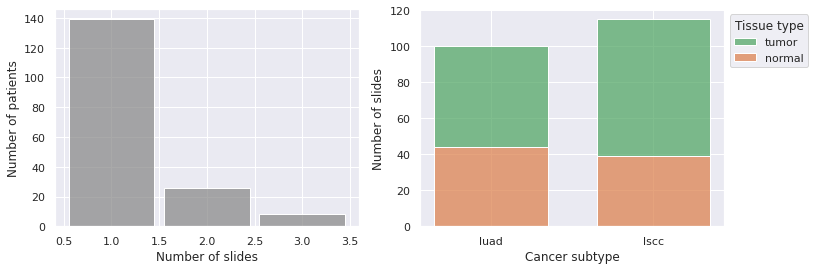

In [171]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# number of slides per patient 
slides_per_patient = slides_df.groupby(['patient_id']).size()
plot1 = sns.histplot(data=slides_per_patient, discrete=True, ax=ax1, shrink=0.9, color=['C7'])
ax1.update({'xlabel': 'Number of slides', 'ylabel': 'Number of patients'})

# distribution of tissue types
plot2 = sns.histplot(data=slides_df, x='cancer_subtype', hue='tissue_type', multiple='stack', palette = ['C2', 'C1'], ax=ax2, shrink=0.7)
ax2.update({'xlabel': 'Cancer subtype', 'ylabel': 'Number of slides'})
legend = plot2.get_legend()
legend.set_title('Tissue type')
legend.set_bbox_to_anchor((1, 1))

Any slide can also be easily viewed and explored in detail using the IDC viewer.

In [172]:
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/slim/studies/" + study_UID

print(get_idc_viewer_url(slides_df['idc_viewer_id'].iloc[0]))
print(get_idc_viewer_url(slides_df['idc_viewer_id'].iloc[100]))

https://viewer.imaging.datacommons.cancer.gov/slim/studies/1.3.6.1.4.1.5962.99.1.2461043434.326367772.1625958714090.3.0
https://viewer.imaging.datacommons.cancer.gov/slim/studies/1.3.6.1.4.1.5962.99.1.2451408823.2122791306.1625949079479.3.0


Finally, we save the information as CSV file `slides_metadata.csv` to be used later for splitting into training, validation and test sets.

In [173]:
slides_metadata_path = os.path.join(input_dir, 'slides_metadata.csv')
slides_df.to_csv(slides_metadata_path, index=False)

## Pathomics experiment

The following pathomics experiment consists of three main steps:

1. **Preprocessing**:
    - Tiling of slides and filtering out of background tiles
    - Separation into training, validation and test dataset
2. **Training**: Per-tile training of the model
3. **Evaluation**: Per-tile and per-slide evaluation of the trained model

### Preprocessing

**Tile generation**: First, the WSI are downloaded with `gsutil` given the respective gcs_url's. Then each slide is tiled into non-overlapping 128x128 pixel windows at a magnification of 5x using the python openslide library. As this experiment is supposed to serve as a demo requiring a minimum amount of runtime, we further reduce the size of our dataset by generating only one in `twenty` tiles per slide. Still the tile generation will take roughly **xxx** time. 

**Generation of datasets**: Next, the tiles are distributed among / sorted into training (70%), test (15%) and validation (15%) datasets, ensuring that tiles associated with a particular patient are not separated, but assigned as a whole to one of these sets. For this purpose, a file (*patient_metadata.csv*) is created that reports the number of tiles available from each patient and is used to generate Figure 3 below. \
Additionally, we update *slides_metadata.csv* by adding the information whether a slide has been assigned to the training, validation or testset. 

In [174]:
from idc_pathomics.data.tile_generation_cptac import generate_tiles

slides_dir = os.path.join(input_dir, 'cptac_slides')
tiles_dir = os.path.join(input_dir, 'cptac_tiles')
if not os.path.exists(slides_dir):
    os.makedirs(slides_dir)

if not os.path.exists(tiles_dir):
    os.makedirs(tiles_dir)
#all tiles 10th slide 
generate_tiles(slides_dir, slides_metadata_path, tiles_dir, save_every_xth_tile=1, google_cloud_project_id=my_project_id)

1/215


Copying gs://idc_dev/51036e43-5622-41a9-af03-603cf2127982.dcm...


Processing slide 93e30fd5-e57e-4503-a175-863c7d_D1_D1 - 2021-09-23 21:12:50.752554


\ [1 files][891.1 MiB/891.1 MiB]   68.0 MiB/s                                   
Operation completed over 1 objects/891.1 MiB.                                    


10355 10355
saved 4956
2/215


Copying gs://idc_dev/c2627b06-f2c8-4117-b091-44c143803bdd.dcm...


Processing slide C3L-00263-21 - 2021-09-23 21:15:25.107269


| [1 files][172.8 MiB/172.8 MiB]                                                
Operation completed over 1 objects/172.8 MiB.                                    


4331 4331
saved 685
3/215


Copying gs://idc_dev/dc81e8eb-aaec-4d65-853e-713ed7512949.dcm...


Processing slide C3L-00279-25 - 2021-09-23 21:16:25.065224


- [1 files][ 93.2 MiB/ 93.2 MiB]                                                
Operation completed over 1 objects/93.2 MiB.                                     


2550 2550
saved 139
4/215


Copying gs://idc_dev/0c066920-2f6c-4212-a825-450250698612.dcm...


Processing slide C3L-00415-23 - 2021-09-23 21:17:03.499817


- [1 files][326.2 MiB/326.2 MiB]                                                
Operation completed over 1 objects/326.2 MiB.                                    


5850 5850
saved 1593
5/215


Copying gs://idc_dev/9fb87720-18a7-4700-a22a-932ff4246222.dcm...


Processing slide C3L-00445-26 - 2021-09-23 21:18:47.382108


- [1 files][  1.5 GiB/  1.5 GiB]   67.0 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


17548 17548
saved 8435
6/215


Copying gs://idc_dev/045851a7-178d-417b-9bd8-a32bb440c494.dcm...


Processing slide C3L-00510-22 - 2021-09-23 21:23:00.109819


\ [1 files][135.2 MiB/135.2 MiB]                                                
Operation completed over 1 objects/135.2 MiB.                                    


3481 3481
saved 593
7/215


Copying gs://idc_dev/80ec2c0e-e246-4a0d-bfcb-3c3d5f31c90b.dcm...


Processing slide C3L-00568-23 - 2021-09-23 21:23:48.448555


- [1 files][ 57.7 MiB/ 57.7 MiB]                                                
Operation completed over 1 objects/57.7 MiB.                                     


1404 1404
saved 220
8/215


Copying gs://idc_dev/ef074e39-d2b8-495a-ae3a-ac0c119b18cf.dcm...


Processing slide C3L-00913-22 - 2021-09-23 21:24:10.919501


| [1 files][189.6 MiB/189.6 MiB]                                                
Operation completed over 1 objects/189.6 MiB.                                    


5183 5183
saved 895
9/215


Copying gs://idc_dev/33856c21-2356-4b3e-9bce-2ceeb6828ed5.dcm...


Processing slide C3L-00965-27 - 2021-09-23 21:25:21.513125


| [1 files][182.6 MiB/182.6 MiB]                                                
Operation completed over 1 objects/182.6 MiB.                                    


3135 3135
saved 886
10/215


Copying gs://idc_dev/255f8b08-b23a-497a-a71f-59e081567104.dcm...


Processing slide C3L-00973-22 - 2021-09-23 21:26:09.404622


- [1 files][362.8 MiB/362.8 MiB]                                                
Operation completed over 1 objects/362.8 MiB.                                    


6210 6210
saved 2459
11/215


Copying gs://idc_dev/6b89d42c-1f1a-42d8-9ab0-4898499350f4.dcm...


Processing slide C3L-01330-22 - 2021-09-23 21:27:36.195724


/ [1 files][ 48.9 MiB/ 48.9 MiB]                                                
Operation completed over 1 objects/48.9 MiB.                                     


1505 1505
saved 192
12/215


Copying gs://idc_dev/c279752f-b23b-473b-a728-f74a19a71201.dcm...


Processing slide C3L-01330-23 - 2021-09-23 21:27:58.229168


- [1 files][ 47.0 MiB/ 47.0 MiB]                                                
Operation completed over 1 objects/47.0 MiB.                                     


936 936
saved 226
13/215


Copying gs://idc_dev/c488f98c-d088-4417-b699-a23783b68749.dcm...


Processing slide C3L-01330-26 - 2021-09-23 21:28:13.584488


- [1 files][ 82.8 MiB/ 82.8 MiB]                                                
Operation completed over 1 objects/82.8 MiB.                                     


1908 1908
saved 311
14/215


Copying gs://idc_dev/2b41fc66-a2ac-49c3-ae9c-a4a04067c229.dcm...


Processing slide C3L-01683-26 - 2021-09-23 21:28:41.151396


\ [1 files][122.0 MiB/122.0 MiB]                                                
Operation completed over 1 objects/122.0 MiB.                                    


2346 2346
saved 633
15/215


Copying gs://idc_dev/b6b5b853-4c79-4167-91b9-ab157bf52d9c.dcm...


Processing slide C3L-01683-29 - 2021-09-23 21:29:17.319248


/ [1 files][293.9 MiB/293.9 MiB]                                                
Operation completed over 1 objects/293.9 MiB.                                    


5106 5106
saved 1634
16/215


Copying gs://idc_dev/09a72195-dbe5-4b66-85af-c79310eededb.dcm...


Processing slide C3L-02127-26 - 2021-09-23 21:30:32.104517


/ [1 files][275.2 MiB/275.2 MiB]                                                
Operation completed over 1 objects/275.2 MiB.                                    


7840 7840
saved 1055
17/215


Copying gs://idc_dev/06eaba45-f099-4fef-ae84-ff963b05634b.dcm...


Processing slide C3L-02163-22 - 2021-09-23 21:32:18.770639


- [1 files][309.3 MiB/309.3 MiB]                                                
Operation completed over 1 objects/309.3 MiB.                                    


7392 7392
saved 1906
18/215


Copying gs://idc_dev/cdd5e14a-97f9-46e7-937c-dac1ad139f13.dcm...


Processing slide C3L-02164-21 - 2021-09-23 21:34:00.215146


/ [1 files][271.4 MiB/271.4 MiB]                                                
Operation completed over 1 objects/271.4 MiB.                                    


3953 3953
saved 1187
19/215


Copying gs://idc_dev/fa04426a-6705-4938-bf5a-af0e4b72d929.dcm...


Processing slide C3L-02164-22 - 2021-09-23 21:34:59.131954


| [1 files][197.0 MiB/197.0 MiB]                                                
Operation completed over 1 objects/197.0 MiB.                                    


2772 2772
saved 1225
20/215


Copying gs://idc_dev/3b133086-1656-4f37-ad73-5e171b51486c.dcm...


Processing slide C3L-02219-22 - 2021-09-23 21:35:40.269691


- [1 files][ 53.3 MiB/ 53.3 MiB]                                                
Operation completed over 1 objects/53.3 MiB.                                     


1116 1116
saved 236
21/215


Copying gs://idc_dev/af4927cd-fbf1-4f85-9d6c-a99e547cea02.dcm...


Processing slide C3L-02349-21 - 2021-09-23 21:35:57.931924


\ [1 files][128.0 MiB/128.0 MiB]                                                
Operation completed over 1 objects/128.0 MiB.                                    


2244 2244
saved 675
22/215


Copying gs://idc_dev/41cee707-1544-45ec-a738-118e0b36756d.dcm...


Processing slide C3L-02358-26 - 2021-09-23 21:36:31.929257


\ [1 files][162.4 MiB/162.4 MiB]                                                
Operation completed over 1 objects/162.4 MiB.                                    


3752 3752
saved 527
23/215


Copying gs://idc_dev/07618e22-807d-420a-a382-80b023925a56.dcm...


Processing slide C3L-02508-24 - 2021-09-23 21:37:24.253604


- [1 files][ 81.2 MiB/ 81.2 MiB]                                                
Operation completed over 1 objects/81.2 MiB.                                     


1365 1365
saved 450
24/215


Copying gs://idc_dev/1b87a9d4-48e7-471e-b146-780faafe6163.dcm...


Processing slide C3L-02515-21 - 2021-09-23 21:37:48.102172


- [1 files][366.9 MiB/366.9 MiB]                                                
Operation completed over 1 objects/366.9 MiB.                                    


2891 2891
saved 823
25/215


Copying gs://idc_dev/c04d01a9-21dd-4409-bc1b-f3402e390f62.dcm...


Processing slide C3L-02546-21 - 2021-09-23 21:38:37.846580


- [1 files][ 72.2 MiB/ 72.2 MiB]                                                
Operation completed over 1 objects/72.2 MiB.                                     


1505 1505
saved 341
26/215


Copying gs://idc_dev/60305202-2b50-465e-b69b-fc886b3801c3.dcm...


Processing slide C3L-02549-26 - 2021-09-23 21:39:01.858431


| [1 files][162.6 MiB/162.6 MiB]                                                
Operation completed over 1 objects/162.6 MiB.                                    


3740 3740
saved 427
27/215


Copying gs://idc_dev/947ee206-529e-45ef-8336-494658a639ae.dcm...


Processing slide C3L-02560-26 - 2021-09-23 21:39:54.477539


- [1 files][ 84.2 MiB/ 84.2 MiB]                                                
Operation completed over 1 objects/84.2 MiB.                                     


1677 1677
saved 405
28/215


Copying gs://idc_dev/22bed122-606b-488a-8af3-bb06c3139b8c.dcm...


Processing slide C3L-02618-23 - 2021-09-23 21:40:22.758001


- [1 files][352.4 MiB/352.4 MiB]                                                
Operation completed over 1 objects/352.4 MiB.                                    


9204 9204
saved 1602
29/215


Copying gs://idc_dev/fb20e642-f248-45a5-8c0d-9a628ffc85e8.dcm...


Processing slide C3L-02619-24 - 2021-09-23 21:42:29.574644


/ [1 files][219.6 MiB/219.6 MiB]                                                
Operation completed over 1 objects/219.6 MiB.                                    


3876 3876
saved 1042
30/215


Copying gs://idc_dev/51778436-e809-4002-b6b4-6556be29cb6a.dcm...


Processing slide C3L-02619-28 - 2021-09-23 21:43:27.434804


\ [1 files][399.0 MiB/399.0 MiB]                                                
Operation completed over 1 objects/399.0 MiB.                                    


9440 9440
saved 1396
31/215


Copying gs://idc_dev/ad596234-f89e-43fc-824d-bdd9491def3a.dcm...


Processing slide C3L-02627-25 - 2021-09-23 21:46:15.051398


- [1 files][320.2 MiB/320.2 MiB]   33.3 MiB/s                                   
Operation completed over 1 objects/320.2 MiB.                                    


7182 7182
saved 1368
32/215


Copying gs://idc_dev/b8e15005-14bd-4c2b-83c6-fe6e63daff42.dcm...


Processing slide C3L-02627-27 - 2021-09-23 21:47:54.201841


/ [1 files][236.6 MiB/236.6 MiB]                                                
Operation completed over 1 objects/236.6 MiB.                                    


6028 6028
saved 732
33/215


Copying gs://idc_dev/79d63483-77aa-4b23-ab72-d7092dcf85fa.dcm...


Processing slide C3L-02629-26 - 2021-09-23 21:49:18.430322


| [1 files][177.8 MiB/177.8 MiB]                                                
Operation completed over 1 objects/177.8 MiB.                                    


5904 5904
saved 459
34/215


Copying gs://idc_dev/10b18e46-110f-4a36-b7cb-a3fb62cc363d.dcm...


Processing slide C3L-02629-27 - 2021-09-23 21:50:39.586616


| [1 files][181.0 MiB/181.0 MiB]                                                
Operation completed over 1 objects/181.0 MiB.                                    


6486 6486
saved 383
35/215


Copying gs://idc_dev/77b8a091-3e05-4bde-aeaf-03d3b17fff7b.dcm...


Processing slide C3L-02660-24 - 2021-09-23 21:52:11.236875


- [1 files][436.4 MiB/436.4 MiB]                                                
Operation completed over 1 objects/436.4 MiB.                                    


6435 6435
saved 1510
36/215


Copying gs://idc_dev/ec855abe-90ec-4bcc-9106-d397de34738f.dcm...


Processing slide C3L-02661-23 - 2021-09-23 21:53:44.851724


| [1 files][217.8 MiB/217.8 MiB]                                                
Operation completed over 1 objects/217.8 MiB.                                    


4410 4410
saved 1039
37/215


Copying gs://idc_dev/df1902f8-1a30-4a7e-a400-a8afbc89bedd.dcm...


Processing slide C3L-02661-25 - 2021-09-23 21:54:51.551563


- [1 files][462.0 MiB/462.0 MiB]                                                
Operation completed over 1 objects/462.0 MiB.                                    


8256 8256
saved 2207
38/215


Copying gs://idc_dev/4cc83428-3ae8-46ec-a54e-a17c082bf272.dcm...


Processing slide C3L-02669-24 - 2021-09-23 21:56:50.231771


/ [1 files][286.5 MiB/286.5 MiB]                                                
Operation completed over 1 objects/286.5 MiB.                                    


6240 6240
saved 1332
39/215


Copying gs://idc_dev/d291390c-20a6-46e5-946f-18cffd0f051d.dcm...


Processing slide C3L-02669-25 - 2021-09-23 21:58:19.206479


/ [1 files][261.6 MiB/261.6 MiB]                                                
Operation completed over 1 objects/261.6 MiB.                                    


6080 6080
saved 1089
40/215


Copying gs://idc_dev/5e6ef4c8-5bbd-4bca-81f6-d4712a5e3bcb.dcm...


Processing slide C3L-02834-25 - 2021-09-23 21:59:41.603494


/ [1 files][ 23.7 MiB/ 23.7 MiB]                                                
Operation completed over 1 objects/23.7 MiB.                                     


812 812
saved 83
41/215


Copying gs://idc_dev/fa859224-c8e1-4112-b2e4-f70a1ff71b93.dcm...


Processing slide C3L-02951-23 - 2021-09-23 21:59:54.746328


- [1 files][115.7 MiB/115.7 MiB]                                                
Operation completed over 1 objects/115.7 MiB.                                    


1599 1599
saved 617
42/215


Copying gs://idc_dev/d80514a2-7b30-4f80-b92f-296299c3cbb1.dcm...


Processing slide C3L-02964-22 - 2021-09-23 22:00:20.937952


\ [1 files][129.9 MiB/129.9 MiB]                                                
Operation completed over 1 objects/129.9 MiB.                                    


2064 2064
saved 677
43/215


Copying gs://idc_dev/f1f03868-afc7-4e5f-b7cf-f9176c565df6.dcm...


Processing slide C3L-03272-21 - 2021-09-23 22:00:52.636547


\ [1 files][140.5 MiB/140.5 MiB]                                                
Operation completed over 1 objects/140.5 MiB.                                    


3969 3969
saved 734
44/215


Copying gs://idc_dev/a9048080-3b60-4b54-93cd-c081e06bc24a.dcm...


Processing slide C3L-03272-24 - 2021-09-23 22:01:47.266872


- [1 files][ 77.3 MiB/ 77.3 MiB]                                                
Operation completed over 1 objects/77.3 MiB.                                     


2703 2703
saved 299
45/215


Copying gs://idc_dev/481b3a22-55a3-4c6b-9650-06ea3bbfe56f.dcm...


Processing slide C3L-03272-26 - 2021-09-23 22:02:24.482200


- [1 files][ 44.4 MiB/ 44.4 MiB]                                                
Operation completed over 1 objects/44.4 MiB.                                     


1404 1404
saved 200
46/215


Copying gs://idc_dev/81efa2c1-7b29-42db-b1ec-9de416f0ea94.dcm...


Processing slide C3L-03462-22 - 2021-09-23 22:02:45.295463


- [1 files][ 55.4 MiB/ 55.4 MiB]                                                
Operation completed over 1 objects/55.4 MiB.                                     


1892 1892
saved 146
47/215


Copying gs://idc_dev/6ae34eb2-7bd3-400b-a6b1-d8b8646a5a9f.dcm...


Processing slide C3L-03462-23 - 2021-09-23 22:03:12.254194


- [1 files][ 69.4 MiB/ 69.4 MiB]                                                
Operation completed over 1 objects/69.4 MiB.                                     


1720 1720
saved 325
48/215


Copying gs://idc_dev/50c53ae1-e677-43c4-950b-e64c58a03fbd.dcm...


Processing slide C3L-03642-22 - 2021-09-23 22:03:42.946408


\ [1 files][494.3 MiB/494.3 MiB]                                                
Operation completed over 1 objects/494.3 MiB.                                    


4480 4480
saved 1894
49/215


Copying gs://idc_dev/b31dc303-64e4-43d4-a3ae-7309c5d22706.dcm...


Processing slide C3L-03678-23 - 2021-09-23 22:04:56.335865


/ [1 files][ 35.3 MiB/ 35.3 MiB]                                                
Operation completed over 1 objects/35.3 MiB.                                     


840 840
saved 221
50/215


Copying gs://idc_dev/36b71321-dbff-4eb7-8193-d83bcd01bb62.dcm...


Processing slide C3L-03726-25 - 2021-09-23 22:05:10.623879


\ [1 files][124.5 MiB/124.5 MiB]                                                
Operation completed over 1 objects/124.5 MiB.                                    


3481 3481
saved 460
51/215


Copying gs://idc_dev/b61d62fc-2251-447f-815a-ffbd637efb34.dcm...


Processing slide C3L-03961-27 - 2021-09-23 22:06:00.107174


| [1 files][220.1 MiB/220.1 MiB]                                                
Operation completed over 1 objects/220.1 MiB.                                    


5265 5265
saved 491
52/215


Copying gs://idc_dev/b7975b59-d244-4ba1-be39-d37afcbb6841.dcm...


Processing slide C3L-03962-23 - 2021-09-23 22:07:14.901045


/ [1 files][258.6 MiB/258.6 MiB]                                                
Operation completed over 1 objects/258.6 MiB.                                    


5424 5424
saved 1238
53/215


Copying gs://idc_dev/5d1a0558-aecf-4d0b-8df8-5bcfc5c83426.dcm...


Processing slide C3L-03965-24 - 2021-09-23 22:08:34.874617


\ [1 files][473.1 MiB/473.1 MiB]                                                
Operation completed over 1 objects/473.1 MiB.                                    


6534 6534
saved 2123
54/215


Copying gs://idc_dev/90c96321-94c5-4db4-b862-1cf9687f41ba.dcm...


Processing slide C3L-03969-28 - 2021-09-23 22:10:10.753390


\ [1 files][144.6 MiB/144.6 MiB]                                                
Operation completed over 1 objects/144.6 MiB.                                    


5076 5076
saved 470
55/215


Copying gs://idc_dev/d2968cec-bd85-4d2f-b51b-57142617e73b.dcm...


Processing slide C3L-03982-28 - 2021-09-23 22:11:24.702873


\ [1 files][479.3 MiB/479.3 MiB]                                                
Operation completed over 1 objects/479.3 MiB.                                    


9936 9936
saved 1301
56/215


Copying gs://idc_dev/db790f9e-c1d2-49fa-a178-2b36038f32ca.dcm...


Processing slide C3L-03985-22 - 2021-09-23 22:13:42.553193


- [1 files][360.3 MiB/360.3 MiB]                                                
Operation completed over 1 objects/360.3 MiB.                                    


6976 6976
saved 1207
57/215


Copying gs://idc_dev/9f03c780-69bd-4455-913c-1c87a08acd15.dcm...


Processing slide C3L-03985-26 - 2021-09-23 22:15:19.767023


\ [1 files][159.4 MiB/159.4 MiB]                                                
Operation completed over 1 objects/159.4 MiB.                                    


5850 5850
saved 242
58/215


Copying gs://idc_dev/fa41b205-1a48-46a7-92f0-55ded13e0d64.dcm...


Processing slide C3L-03987-23 - 2021-09-23 22:16:39.758434


| [1 files][182.2 MiB/182.2 MiB]                                                
Operation completed over 1 objects/182.2 MiB.                                    


2832 2832
saved 545
59/215


Copying gs://idc_dev/6b8eef9a-b8f4-48b3-b635-4134ba418953.dcm...


Processing slide C3L-03987-26 - 2021-09-23 22:17:22.670870


| [1 files][224.1 MiB/224.1 MiB]                                                
Operation completed over 1 objects/224.1 MiB.                                    


5650 5650
saved 435
60/215


Copying gs://idc_dev/8076944d-8ee3-44df-8f82-97bef5553dc1.dcm...


Processing slide C3L-04031-23 - 2021-09-23 22:18:44.323364


- [1 files][447.8 MiB/447.8 MiB]                                                
Operation completed over 1 objects/447.8 MiB.                                    


9648 9648
saved 1850
61/215


Copying gs://idc_dev/71cc77d0-ab67-484f-a15c-d6c29e327326.dcm...


Processing slide C3L-04031-25 - 2021-09-23 22:21:01.202567


/ [1 files][584.3 MiB/584.3 MiB]                                                
Operation completed over 1 objects/584.3 MiB.                                    


11256 11256
saved 2689
62/215


Copying gs://idc_dev/0b6441c1-93dd-4176-8038-44c1144ff2f5.dcm...


Processing slide C3L-04031-28 - 2021-09-23 22:23:36.247602


/ [1 files][401.6 MiB/401.6 MiB]                                                
Operation completed over 1 objects/401.6 MiB.                                    


7920 7920
saved 1441
63/215


Copying gs://idc_dev/05b9b192-cead-472c-8792-0252ac92a09b.dcm...


Processing slide C3L-04037-21 - 2021-09-23 22:25:24.524966


| [1 files][224.8 MiB/224.8 MiB]                                                
Operation completed over 1 objects/224.8 MiB.                                    


6439 6439
saved 914
64/215


Copying gs://idc_dev/cad2a8af-67a4-4b26-b2ee-cca95072c26a.dcm...


Processing slide C3L-04334-28 - 2021-09-23 22:26:52.998311


\ [1 files][366.7 MiB/366.7 MiB]                                                
Operation completed over 1 objects/366.7 MiB.                                    


6588 6588
saved 1103
65/215


Copying gs://idc_dev/df27b97f-ffb1-44ec-9f49-7dcdab1123a2.dcm...


Processing slide C3L-04361-21 - 2021-09-23 22:28:35.002221


| [1 files][614.6 MiB/614.6 MiB]                                                
Operation completed over 1 objects/614.6 MiB.                                    


13464 13464
saved 3067
66/215


Copying gs://idc_dev/5a23c2cf-4e8d-4179-b6ff-bc45953087a9.dcm...


Processing slide C3L-04365-21 - 2021-09-23 22:31:36.656421


\ [1 files][131.1 MiB/131.1 MiB]                                                
Operation completed over 1 objects/131.1 MiB.                                    


4360 4360
saved 442
67/215


Copying gs://idc_dev/3bdc4e6c-4daf-4ad6-a8b8-63b0a60077fc.dcm...


Processing slide C3L-04378-22 - 2021-09-23 22:32:35.311905


- [1 files][ 95.8 MiB/ 95.8 MiB]                                                
Operation completed over 1 objects/95.8 MiB.                                     


2530 2530
saved 235
68/215


Copying gs://idc_dev/ac689a59-994e-45bc-a6eb-f750270dbf25.dcm...


Processing slide C3L-04391-26 - 2021-09-23 22:33:10.382219


/ [1 files][ 40.2 MiB/ 40.2 MiB]                                                
Operation completed over 1 objects/40.2 MiB.                                     


1216 1216
saved 135
69/215


Copying gs://idc_dev/eb69652f-04f7-4644-9446-a2f17497ca42.dcm...


Processing slide C3L-04404-21 - 2021-09-23 22:33:28.304683


- [1 files][ 60.7 MiB/ 60.7 MiB]                                                
Operation completed over 1 objects/60.7 MiB.                                     


896 896
saved 253
70/215


Copying gs://idc_dev/88c916b5-7348-4de3-adc2-8b553a1e9998.dcm...


Processing slide C3L-04410-23 - 2021-09-23 22:33:44.613986


/ [1 files][265.4 MiB/265.4 MiB]                                                
Operation completed over 1 objects/265.4 MiB.                                    


3068 3068
saved 1218
71/215


Copying gs://idc_dev/3ecbed87-533c-4a3f-8813-1bfcefda13a5.dcm...


Processing slide C3L-04746-22 - 2021-09-23 22:34:35.341608


- [1 files][489.7 MiB/489.7 MiB]                                                
Operation completed over 1 objects/489.7 MiB.                                    


9576 9576
saved 1894
72/215


Copying gs://idc_dev/3d62fea4-c0bd-4df7-a43c-a270f1a59979.dcm...


Processing slide C3L-04759-22 - 2021-09-23 22:36:49.032817


- [1 files][355.6 MiB/355.6 MiB]                                                
Operation completed over 1 objects/355.6 MiB.                                    


8178 8178
saved 1648
73/215


Copying gs://idc_dev/60d5b90f-1fa0-4cc2-a7f4-7d3a552f6c97.dcm...


Processing slide C3L-04759-26 - 2021-09-23 22:38:41.923727


- [1 files][347.6 MiB/347.6 MiB]                                                
Operation completed over 1 objects/347.6 MiB.                                    


7448 7448
saved 1365
74/215


Copying gs://idc_dev/2887c3a8-aafb-4f97-be32-3376e52915e8.dcm...


Processing slide C3L-04786-24 - 2021-09-23 22:40:32.692455


- [1 files][694.3 MiB/694.3 MiB]   69.5 MiB/s                                   
Operation completed over 1 objects/694.3 MiB.                                    


14256 14256
saved 2952
75/215


Copying gs://idc_dev/ddd7cb41-22a5-4b00-b139-bb6340b92f05.dcm...


Processing slide C3L-04786-25 - 2021-09-23 22:43:55.749660


/ [1 files][815.2 MiB/815.2 MiB]   68.5 MiB/s                                   
Operation completed over 1 objects/815.2 MiB.                                    


12300 12300
saved 3894
76/215


Copying gs://idc_dev/f625f543-615e-44b6-8c7d-af85e7c6f564.dcm...


Processing slide C3L-04786-27 - 2021-09-23 22:46:58.608913


| [1 files][768.0 MiB/768.0 MiB]   68.8 MiB/s                                   
Operation completed over 1 objects/768.0 MiB.                                    


14025 14025
saved 2219
77/215


Copying gs://idc_dev/d0ee78ac-b321-46ad-927f-7b2e14fefb86.dcm...


Processing slide C3L-04792-22 - 2021-09-23 22:50:17.303556


| [1 files][547.5 MiB/547.5 MiB]                                                
Operation completed over 1 objects/547.5 MiB.                                    


9555 9555
saved 2413
78/215


Copying gs://idc_dev/8fe87c09-6e66-482a-ae96-ed8ccdc6f4cf.dcm...


Processing slide C3L-04804-26 - 2021-09-23 22:52:34.997530


| [1 files][587.1 MiB/587.1 MiB]                                                
Operation completed over 1 objects/587.1 MiB.                                    


10640 10640
saved 614
79/215


Copying gs://idc_dev/3639768c-4177-48e3-b25f-9be481f41f50.dcm...


Processing slide C3L-04854-21 - 2021-09-23 22:55:02.920049


| [1 files][198.3 MiB/198.3 MiB]                                                
Operation completed over 1 objects/198.3 MiB.                                    


2193 2193
saved 775
80/215


Copying gs://idc_dev/66de1476-9bd2-41d4-a2a3-bc74b2c9ab1a.dcm...


Processing slide C3L-04854-24 - 2021-09-23 22:55:37.904300


| [1 files][187.6 MiB/187.6 MiB]                                                
Operation completed over 1 objects/187.6 MiB.                                    


2640 2640
saved 625
81/215


Copying gs://idc_dev/193f3ead-a82c-4ef1-a1e7-bff6c7ebe135.dcm...


Processing slide C3L-04866-27 - 2021-09-23 22:56:19.130814


\ [1 files][398.8 MiB/398.8 MiB]                                                
Operation completed over 1 objects/398.8 MiB.                                    


11232 11232
saved 1151
82/215


Copying gs://idc_dev/e0bdd25b-254b-4683-8eeb-3d37ecd545c9.dcm...


Processing slide C3L-04868-21 - 2021-09-23 22:58:59.380713


/ [1 files][857.4 MiB/857.4 MiB]   72.4 MiB/s                                   
Operation completed over 1 objects/857.4 MiB.                                    


13246 13246
saved 4879
83/215


Copying gs://idc_dev/aa789ad1-c3b6-432d-9805-a3d127071c4c.dcm...


Processing slide C3L-04868-28 - 2021-09-23 23:02:14.293444


| [1 files][637.1 MiB/637.1 MiB]                                                
Operation completed over 1 objects/637.1 MiB.                                    


11680 11680
saved 3002
84/215


Copying gs://idc_dev/1aba55fb-ddf3-4b41-bbdf-64ad73160d76.dcm...


Processing slide C3L-04871-24 - 2021-09-23 23:04:58.627641


/ [1 files][438.6 MiB/438.6 MiB]                                                
Operation completed over 1 objects/438.6 MiB.                                    


9504 9504
saved 1940
85/215


Copying gs://idc_dev/9d8196f8-69ce-452b-8f1d-87a08d6986c7.dcm...


Processing slide C3L-04873-25 - 2021-09-23 23:07:09.945995


- [1 files][345.5 MiB/345.5 MiB]                                                
Operation completed over 1 objects/345.5 MiB.                                    


6572 6572
saved 1709
86/215


Copying gs://idc_dev/cf835766-0a2b-4a79-a1e1-1bd10069a407.dcm...


Processing slide C3L-04874-28 - 2021-09-23 23:08:43.018950


| [1 files][196.0 MiB/196.0 MiB]                                                
Operation completed over 1 objects/196.0 MiB.                                    


4032 4032
saved 507
87/215


Copying gs://idc_dev/b3c9d24a-12b8-4fd5-ae6d-482be0f7db03.dcm...


Processing slide C3L-04880-21 - 2021-09-23 23:09:40.923743


\ [1 files][370.7 MiB/370.7 MiB]                                                
Operation completed over 1 objects/370.7 MiB.                                    


3780 3780
saved 1429
88/215


Copying gs://idc_dev/87dc48fe-13f0-4c8b-92c9-04c51db6e4ab.dcm...


Processing slide C3L-04880-22 - 2021-09-23 23:10:39.967395


- [1 files][350.5 MiB/350.5 MiB]                                                
Operation completed over 1 objects/350.5 MiB.                                    


3969 3969
saved 1293
89/215


Copying gs://idc_dev/8423336f-867a-493c-87c5-9b8d63afcb57.dcm...


Processing slide C3L-04880-26 - 2021-09-23 23:11:39.543146


\ [1 files][167.2 MiB/167.2 MiB]                                                
Operation completed over 1 objects/167.2 MiB.                                    


3245 3245
saved 413
90/215


Copying gs://idc_dev/5df91df7-b3a1-459a-a3a4-4d03fd60248c.dcm...


Processing slide C3L-04883-26 - 2021-09-23 23:12:28.053406


- [1 files][361.2 MiB/361.2 MiB]                                                
Operation completed over 1 objects/361.2 MiB.                                    


9306 9306
saved 1381
91/215


Copying gs://idc_dev/32c55929-3856-4eac-939f-98f52a116cd2.dcm...


Processing slide C3L-04883-27 - 2021-09-23 23:14:36.032142


- [1 files][357.6 MiB/357.6 MiB]                                                
Operation completed over 1 objects/357.6 MiB.                                    


9504 9504
saved 1352
92/215


Copying gs://idc_dev/2769588b-795b-403f-8c31-e1ea7c27e273.dcm...


Processing slide C3L-04889-21 - 2021-09-23 23:16:48.282506


\ [1 files][527.0 MiB/527.0 MiB]                                                
Operation completed over 1 objects/527.0 MiB.                                    


10164 10164
saved 2442
93/215


Copying gs://idc_dev/8d3bd193-3cc3-4409-b4ba-b0005a94c62f.dcm...


Processing slide C3L-04912-21 - 2021-09-23 23:19:10.778600


\ [1 files][385.1 MiB/385.1 MiB]                                                
Operation completed over 1 objects/385.1 MiB.                                    


10920 10920
saved 1393
94/215


Copying gs://idc_dev/129c4963-2638-4d5b-bc80-971313e94ffc.dcm...


Processing slide C3L-04916-28 - 2021-09-23 23:21:35.773873


- [1 files][319.9 MiB/319.9 MiB]                                                
Operation completed over 1 objects/319.9 MiB.                                    


4180 4180
saved 1726
95/215


Copying gs://idc_dev/e42c92e3-cf2a-4831-bf02-c92f63fc22fa.dcm...


Processing slide C3L-04922-27 - 2021-09-23 23:22:42.958539


| [1 files][581.0 MiB/581.0 MiB]                                                
Operation completed over 1 objects/581.0 MiB.                                    


11180 11180
saved 2172
96/215


Copying gs://idc_dev/43144edd-47ff-493c-9271-e660dfa5d6ed.dcm...


Processing slide C3L-05145-24 - 2021-09-23 23:25:32.118110


| [1 files][  1.2 GiB/  1.2 GiB]   75.8 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


20868 20868
saved 5020
97/215


Copying gs://idc_dev/771cb140-ae28-443f-8c52-df2da48598ff.dcm...


Processing slide C3L-05172-21 - 2021-09-23 23:30:37.215894


\ [1 files][  1.4 GiB/  1.4 GiB]   71.9 MiB/s                                   
Operation completed over 1 objects/1.4 GiB.                                      


13134 13134
saved 6361
98/215


Copying gs://idc_dev/8c182734-8a38-4de1-8fa1-93ee470d3bca.dcm...


Processing slide C3L-05172-23 - 2021-09-23 23:34:03.555673


/ [1 files][845.5 MiB/845.5 MiB]   69.0 MiB/s                                   
Operation completed over 1 objects/845.5 MiB.                                    


10184 10184
saved 3102
99/215


Copying gs://idc_dev/568f98bd-b627-421d-96ab-e1424f2514ed.dcm...


Processing slide C3L-05172-26 - 2021-09-23 23:36:34.224918


- [1 files][316.9 MiB/316.9 MiB]                                                
Operation completed over 1 objects/316.9 MiB.                                    


6028 6028
saved 851
100/215


Copying gs://idc_dev/1b7e777f-f886-49fa-b2c1-26f66c63e3cf.dcm...


Processing slide C3L-05212-23 - 2021-09-23 23:38:08.819737


/ [1 files][854.0 MiB/854.0 MiB]   71.0 MiB/s                                   
Operation completed over 1 objects/854.0 MiB.                                    


18330 18330
saved 2113
101/215


Copying gs://idc_dev/033a9bfd-d53d-40c3-83b2-5ce1c37570df.dcm...


Processing slide C3L-05369-21 - 2021-09-23 23:42:30.244509


/ [1 files][626.2 MiB/626.2 MiB]                                                
Operation completed over 1 objects/626.2 MiB.                                    


13072 13072
saved 2803
102/215


Copying gs://idc_dev/2e1650d6-4d41-4e8e-96f9-87720c25dec9.dcm...


Processing slide C3L-05392-26 - 2021-09-23 23:45:31.330696


/ [1 files][416.3 MiB/416.3 MiB]                                                
Operation completed over 1 objects/416.3 MiB.                                    


6674 6674
saved 2048
103/215


Copying gs://idc_dev/167f0216-1ad5-44ae-9ea9-6b8b7bffd706.dcm...


Processing slide C3L-05393-22 - 2021-09-23 23:47:15.253839


- [1 files][748.4 MiB/748.4 MiB]   73.4 MiB/s                                   
Operation completed over 1 objects/748.4 MiB.                                    


13440 13440
saved 3784
104/215


Copying gs://idc_dev/a7312cf5-d219-4f30-9f9c-843bcad766c5.dcm...


Processing slide C3L-05393-26 - 2021-09-23 23:50:25.376427


\ [1 files][496.6 MiB/496.6 MiB]                                                
Operation completed over 1 objects/496.6 MiB.                                    


11840 11840
saved 1666
105/215


Copying gs://idc_dev/9db097c9-0bb0-4761-97b3-bf3abf9faee0.dcm...


Processing slide C3L-05393-27 - 2021-09-23 23:53:10.147576


- [1 files][465.1 MiB/465.1 MiB]                                                
Operation completed over 1 objects/465.1 MiB.                                    


10824 10824
saved 1496
106/215


Copying gs://idc_dev/eb75122a-5539-44a1-a63d-41dc5c293510.dcm...


Processing slide C3L-05395-22 - 2021-09-23 23:55:42.619700


| [1 files][561.7 MiB/561.7 MiB]                                                
Operation completed over 1 objects/561.7 MiB.                                    


12008 12008
saved 2095
107/215


Copying gs://idc_dev/877d9c05-056b-49cd-85b5-bd40b82be12d.dcm...


Processing slide C3L-05395-24 - 2021-09-23 23:58:34.544530


/ [1 files][553.5 MiB/553.5 MiB]                                                
Operation completed over 1 objects/553.5 MiB.                                    


9360 9360
saved 2570
108/215


Copying gs://idc_dev/e579fd25-02ae-4bd3-99b0-f407774ba0f0.dcm...


Processing slide C3L-05398-21 - 2021-09-24 00:00:48.183387


- [1 files][326.2 MiB/326.2 MiB]                                                
Operation completed over 1 objects/326.2 MiB.                                    


8470 8470
saved 1133
109/215


Copying gs://idc_dev/c182eed7-52a9-46b3-90b1-6732157ba883.dcm...


Processing slide C3L-05398-27 - 2021-09-24 00:02:44.576884


- [1 files][307.6 MiB/307.6 MiB]                                                
Operation completed over 1 objects/307.6 MiB.                                    


7548 7548
saved 1257
110/215


Copying gs://idc_dev/a9207798-04cc-4390-b8f5-393d5fbbe124.dcm...


Processing slide C3L-05399-27 - 2021-09-24 00:04:28.987908


\ [1 files][390.1 MiB/390.1 MiB]                                                
Operation completed over 1 objects/390.1 MiB.                                    


7049 7049
saved 1736
111/215


Copying gs://idc_dev/2070cac7-9e48-4584-9893-dff0ca3dbc6e.dcm...


Processing slide C3L-05411-23 - 2021-09-24 00:06:10.771045


- [1 files][455.0 MiB/455.0 MiB]                                                
Operation completed over 1 objects/455.0 MiB.                                    


7315 7315
saved 2413
112/215


Copying gs://idc_dev/8c80ef5f-7648-4adf-b03f-d33fe4870356.dcm...


Processing slide C3L-05422-25 - 2021-09-24 00:07:58.119852


- [1 files][497.9 MiB/497.9 MiB]                                                
Operation completed over 1 objects/497.9 MiB.                                    


9438 9438
saved 2614
113/215


Copying gs://idc_dev/ac91d308-d358-4d01-a86b-539151fff6d4.dcm...


Processing slide C3L-05427-26 - 2021-09-24 00:10:14.232141


| [1 files][552.1 MiB/552.1 MiB]                                                
Operation completed over 1 objects/552.1 MiB.                                    


10988 10988
saved 2350
114/215


Copying gs://idc_dev/4a502482-8424-4199-a81a-c1c16e5fe8dc.dcm...


Processing slide C3N-00169-26 - 2021-09-24 00:12:48.707599


- [1 files][466.1 MiB/466.1 MiB]                                                
Operation completed over 1 objects/466.1 MiB.                                    


7830 7830
saved 2965
115/215


Copying gs://idc_dev/de385e68-8d53-4d23-83bd-b5faae4d94a4.dcm...


Processing slide C3N-00175-22 - 2021-09-24 00:14:39.905645


- [1 files][346.1 MiB/346.1 MiB]                                                
Operation completed over 1 objects/346.1 MiB.                                    


4440 4440
saved 2364
116/215


Copying gs://idc_dev/17e4acde-b4c9-4aec-859a-1398cf77c5c3.dcm...


Processing slide C3N-00199-27 - 2021-09-24 00:15:47.087897


| [1 files][230.8 MiB/230.8 MiB]                                                
Operation completed over 1 objects/230.8 MiB.                                    


7872 7872
saved 868
117/215


Copying gs://idc_dev/19a1dbea-f0ef-4d99-aadf-c35c793d38d4.dcm...


Processing slide C3N-00211-23 - 2021-09-24 00:17:31.026918


- [1 files][ 54.9 MiB/ 54.9 MiB]                                                
Operation completed over 1 objects/54.9 MiB.                                     


1280 1280
saved 368
118/215


Copying gs://idc_dev/50dad8fe-ff5b-44d1-940c-787f9286142c.dcm...


Processing slide C3N-00211-26 - 2021-09-24 00:17:50.414477


\ [1 files][101.2 MiB/101.2 MiB]                                                
Operation completed over 1 objects/101.2 MiB.                                    


1763 1763
saved 651
119/215


Copying gs://idc_dev/68435721-2ba7-4f92-8038-671e00d4ede9.dcm...


Processing slide C3N-00221-26 - 2021-09-24 00:18:18.135944


| [1 files][161.3 MiB/161.3 MiB]                                                
Operation completed over 1 objects/161.3 MiB.                                    


4914 4914
saved 628
120/215


Copying gs://idc_dev/4392bf19-c219-4627-b19a-8a4c348937f4.dcm...


Processing slide C3N-00229-29 - 2021-09-24 00:19:26.024688


| [1 files][163.8 MiB/163.8 MiB]                                                
Operation completed over 1 objects/163.8 MiB.                                    


3196 3196
saved 566
121/215


Copying gs://idc_dev/6e2ab584-aae1-42b2-98c8-fec415d48c37.dcm...


Processing slide C3N-00294-25 - 2021-09-24 00:20:16.079667


/ [1 files][441.6 MiB/441.6 MiB]                                                
Operation completed over 1 objects/441.6 MiB.                                    


12240 12240
saved 3176
122/215


Copying gs://idc_dev/c8945920-71ec-4360-b746-c20c8bc4db0c.dcm...


Processing slide C3N-00433-23 - 2021-09-24 00:23:05.660263


/ [1 files][279.2 MiB/279.2 MiB]                                                
Operation completed over 1 objects/279.2 MiB.                                    


5183 5183
saved 1307
123/215


Copying gs://idc_dev/2182e86b-3274-482d-923c-0edfa34d2817.dcm...


Processing slide C3N-00497-21 - 2021-09-24 00:24:19.204838


\ [1 files][129.6 MiB/129.6 MiB]                                                
Operation completed over 1 objects/129.6 MiB.                                    


4134 4134
saved 534
124/215


Copying gs://idc_dev/e81b0a09-ae3e-41d7-a3ee-2d0956507145.dcm...


Processing slide C3N-00545-26 - 2021-09-24 00:25:16.225257


\ [1 files][152.2 MiB/152.2 MiB]                                                
Operation completed over 1 objects/152.2 MiB.                                    


5041 5041
saved 293
125/215


Copying gs://idc_dev/0783bfde-d535-4624-8629-05955d4ca125.dcm...


Processing slide C3N-00545-27 - 2021-09-24 00:26:24.186707


\ [1 files][139.3 MiB/139.3 MiB]                                                
Operation completed over 1 objects/139.3 MiB.                                    


5246 5246
saved 234
126/215


Copying gs://idc_dev/d87c72e2-eed2-4fca-b6f0-f41b6c685e26.dcm...


Processing slide C3N-00547-26 - 2021-09-24 00:27:39.814660


| [1 files][563.8 MiB/563.8 MiB]                                                
Operation completed over 1 objects/563.8 MiB.                                    


7826 7826
saved 3409
127/215


Copying gs://idc_dev/f2722069-53df-4e48-ba03-f345285fd794.dcm...


Processing slide C3N-00551-22 - 2021-09-24 00:29:37.427300


- [1 files][489.6 MiB/489.6 MiB]                                                
Operation completed over 1 objects/489.6 MiB.                                    


7840 7840
saved 2961
128/215


Copying gs://idc_dev/14441c44-59e6-4714-8eb6-f05c812bfaf4.dcm...


Processing slide C3N-00551-23 - 2021-09-24 00:31:32.413392


/ [1 files][400.6 MiB/400.6 MiB]                                                
Operation completed over 1 objects/400.6 MiB.                                    


5550 5550
saved 2877
129/215


Copying gs://idc_dev/54144b98-03d5-4422-a687-91c7d8950f6d.dcm...


Processing slide C3N-00551-24 - 2021-09-24 00:32:56.332771


\ [1 files][400.0 MiB/400.0 MiB]                                                
Operation completed over 1 objects/400.0 MiB.                                    


6708 6708
saved 2915
130/215


Copying gs://idc_dev/070ec781-b032-489f-af7a-e54e6fd6fd79.dcm...


Processing slide C3N-00556-26 - 2021-09-24 00:34:33.603931


/ [1 files][294.1 MiB/294.1 MiB]                                                
Operation completed over 1 objects/294.1 MiB.                                    


5920 5920
saved 1879
131/215


Copying gs://idc_dev/8bbbe9bb-b832-4c51-9650-609b51f4db7f.dcm...


Processing slide C3N-00560-27 - 2021-09-24 00:36:00.568266


- [1 files][436.1 MiB/436.1 MiB]                                                
Operation completed over 1 objects/436.1 MiB.                                    


7840 7840
saved 2821
132/215


Copying gs://idc_dev/1190ff3b-2080-4483-ad1a-822d4b190403.dcm...


Processing slide C3N-00574-27 - 2021-09-24 00:37:55.844696


\ [1 files][522.4 MiB/522.4 MiB]                                                
Operation completed over 1 objects/522.4 MiB.                                    


8058 8058
saved 3202
133/215


Copying gs://idc_dev/84cac50f-b585-4ca2-a653-481b37238095.dcm...


Processing slide C3N-00704-23 - 2021-09-24 00:39:52.613287


\ [1 files][377.6 MiB/377.6 MiB]                                                
Operation completed over 1 objects/377.6 MiB.                                    


8631 8631
saved 1657
134/215


Copying gs://idc_dev/34903082-cfc6-4a85-845e-eb1f5dd4fda5.dcm...


Processing slide C3N-00737-22 - 2021-09-24 00:41:50.404587


\ [1 files][130.7 MiB/130.7 MiB]                                                
Operation completed over 1 objects/130.7 MiB.                                    


5512 5512
saved 403
135/215


Copying gs://idc_dev/0755163f-7265-4658-9eb6-0dc0d44518de.dcm...


Processing slide C3N-00738-23 - 2021-09-24 00:43:03.962759


| [1 files][215.2 MiB/215.2 MiB]                                                
Operation completed over 1 objects/215.2 MiB.                                    


5586 5586
saved 1013
136/215


Copying gs://idc_dev/42da2d5b-e245-4578-a280-51abdceeaa5b.dcm...


Processing slide C3N-00738-24 - 2021-09-24 00:44:22.247319


/ [1 files][221.5 MiB/221.5 MiB]                                                
Operation completed over 1 objects/221.5 MiB.                                    


5453 5453
saved 1058
137/215


Copying gs://idc_dev/1e8e4c30-8393-4744-a5a9-8d1a08c2b573.dcm...


Processing slide C3N-00839-23 - 2021-09-24 00:45:38.886062


\ [1 files][350.2 MiB/350.2 MiB]                                                
Operation completed over 1 objects/350.2 MiB.                                    


5772 5772
saved 1955
138/215


Copying gs://idc_dev/65da1583-6253-4295-907e-90ecab20f854.dcm...


Processing slide C3N-01018-21 - 2021-09-24 00:47:09.157339


- [1 files][602.5 MiB/602.5 MiB]                                                
Operation completed over 1 objects/602.5 MiB.                                    


8084 8084
saved 3651
139/215


Copying gs://idc_dev/aeee1bb5-ddca-4bb8-babc-c08dd2160739.dcm...


Processing slide C3N-01020-26 - 2021-09-24 00:49:12.026952


| [1 files][578.3 MiB/578.3 MiB]                                                
Operation completed over 1 objects/578.3 MiB.                                    


10028 10028
saved 3275
140/215


Copying gs://idc_dev/057edc63-ddb9-478d-8350-89cab5d36c0b.dcm...


Processing slide C3N-01024-21 - 2021-09-24 00:51:38.340118


| [1 files][512.7 MiB/512.7 MiB]                                                
Operation completed over 1 objects/512.7 MiB.                                    


7548 7548
saved 3156
141/215


Copying gs://idc_dev/49002bde-f045-4fcf-974d-66d75a986ec4.dcm...


Processing slide C3N-01025-21 - 2021-09-24 00:53:33.683416


\ [1 files][615.2 MiB/615.2 MiB]                                                
Operation completed over 1 objects/615.2 MiB.                                    


9078 9078
saved 4182
142/215


Copying gs://idc_dev/47b34c15-fb51-41e0-92f4-2a62a772682e.dcm...


Processing slide C3N-01028-24 - 2021-09-24 00:55:47.129682


\ [1 files][528.2 MiB/528.2 MiB]                                                
Operation completed over 1 objects/528.2 MiB.                                    


8502 8502
saved 3296
143/215


Copying gs://idc_dev/23b9bdc5-2d2b-4f4a-a618-81b8df6f4c07.dcm...


Processing slide C3N-01072-27 - 2021-09-24 00:57:51.332070


/ [1 files][421.6 MiB/421.6 MiB]                                                
Operation completed over 1 objects/421.6 MiB.                                    


8466 8466
saved 2165
144/215


Copying gs://idc_dev/960a82a4-b371-4906-ac71-0684fa0085d1.dcm...


Processing slide C3N-01405-22 - 2021-09-24 00:59:49.910584


/ [1 files][279.4 MiB/279.4 MiB]                                                
Operation completed over 1 objects/279.4 MiB.                                    


5590 5590
saved 1575
145/215


Copying gs://idc_dev/a597fc8f-a398-4064-bdfb-0e8e5f4cb8f0.dcm...


Processing slide C3N-01405-23 - 2021-09-24 01:01:11.067621


\ [1 files][373.4 MiB/373.4 MiB]                                                
Operation completed over 1 objects/373.4 MiB.                                    


6232 6232
saved 2239
146/215


Copying gs://idc_dev/20498764-ec92-496e-8e6b-aba32ccd757a.dcm...


Processing slide C3N-01409-21 - 2021-09-24 01:02:44.713047


\ [1 files][498.5 MiB/498.5 MiB]                                                
Operation completed over 1 objects/498.5 MiB.                                    


7854 7854
saved 3075
147/215


Copying gs://idc_dev/d9ad888c-8465-48da-a1e7-fc7d451a106f.dcm...


Processing slide C3N-01409-23 - 2021-09-24 01:04:41.798012


/ [1 files][847.8 MiB/847.8 MiB]                                                
Operation completed over 1 objects/847.8 MiB.                                    


10961 10961
saved 5706
148/215


Copying gs://idc_dev/4f58c2bd-0d3e-4462-a287-3e168ceb67c5.dcm...


Processing slide C3N-01410-26 - 2021-09-24 01:07:24.107304


- [1 files][291.8 MiB/291.8 MiB]                                                
Operation completed over 1 objects/291.8 MiB.                                    


6536 6536
saved 1480
149/215


Copying gs://idc_dev/6b86eea6-bd04-4caf-a398-437b72f30d58.dcm...


Processing slide C3N-01411-22 - 2021-09-24 01:09:00.031436


| [1 files][554.4 MiB/554.4 MiB]                                                
Operation completed over 1 objects/554.4 MiB.                                    


6708 6708
saved 3698
150/215


Copying gs://idc_dev/857f2ccb-a687-48c6-bf43-86c866589b5a.dcm...


Processing slide C3N-01413-24 - 2021-09-24 01:10:43.424472


\ [1 files][377.0 MiB/377.0 MiB]                                                
Operation completed over 1 objects/377.0 MiB.                                    


6364 6364
saved 2299
151/215


Copying gs://idc_dev/7b1e5fbf-3c5a-4b53-98cb-35c6991683e1.dcm...


Processing slide C3N-01419-27 - 2021-09-24 01:12:17.093111


- [1 files][323.7 MiB/323.7 MiB]                                                
Operation completed over 1 objects/323.7 MiB.                                    


7144 7144
saved 1863
152/215


Copying gs://idc_dev/bcc6da0f-d1ec-4da3-8e60-ec29f87064c7.dcm...


Processing slide C3N-01489-23 - 2021-09-24 01:14:01.034357


\ [1 files][500.6 MiB/500.6 MiB]                                                
Operation completed over 1 objects/500.6 MiB.                                    


7482 7482
saved 3004
153/215


Copying gs://idc_dev/b79955a9-1105-491a-bb52-6c1943b6137f.dcm...


Processing slide C3N-01799-27 - 2021-09-24 01:15:50.049788


| [1 files][224.0 MiB/224.0 MiB]                                                
Operation completed over 1 objects/224.0 MiB.                                    


8234 8234
saved 809
154/215


Copying gs://idc_dev/53147db2-e57b-42d8-8dbf-256dc5decc7b.dcm...


Processing slide C3N-01846-22 - 2021-09-24 01:17:37.841722


\ [1 files][136.2 MiB/136.2 MiB]                                                
Operation completed over 1 objects/136.2 MiB.                                    


2772 2772
saved 652
155/215


Copying gs://idc_dev/753058be-b850-4541-9681-4fa076c0dff3.dcm...


Processing slide C3N-02087-23 - 2021-09-24 01:18:29.863903


\ [1 files][866.0 MiB/866.0 MiB]   67.8 MiB/s                                   
Operation completed over 1 objects/866.0 MiB.                                    


11610 11610
saved 4873
156/215


Copying gs://idc_dev/90806f6c-c2e2-447b-9bd1-2f9213ae6fdc.dcm...


Processing slide C3N-02088-21 - 2021-09-24 01:21:23.933514


\ [1 files][650.8 MiB/650.8 MiB]                                                
Operation completed over 1 objects/650.8 MiB.                                    


9483 9483
saved 4730
157/215


Copying gs://idc_dev/56312678-e9a7-4391-8f36-1a3c1d0f9039.dcm...


Processing slide C3N-02089-24 - 2021-09-24 01:23:49.144872


\ [1 files][771.7 MiB/771.7 MiB]   71.4 MiB/s                                   
Operation completed over 1 objects/771.7 MiB.                                    


10170 10170
saved 4986
158/215


Copying gs://idc_dev/6ddf7c50-0daa-4714-bd79-f2707969f6c1.dcm...


Processing slide C3N-02090-26 - 2021-09-24 01:26:23.536622


| [1 files][653.2 MiB/653.2 MiB]                                                
Operation completed over 1 objects/653.2 MiB.                                    


10764 10764
saved 3692
159/215


Copying gs://idc_dev/a1a85a4d-a789-4a42-aded-d2f2ceeb9ce8.dcm...


Processing slide C3N-02141-23 - 2021-09-24 01:29:02.379835


| [1 files][673.8 MiB/673.8 MiB]                                                
Operation completed over 1 objects/673.8 MiB.                                    


9718 9718
saved 4072
160/215


Copying gs://idc_dev/404ac2a4-235f-4632-9c85-4f33f690ac5a.dcm...


Processing slide C3N-02146-24 - 2021-09-24 01:31:27.579187


- [1 files][636.5 MiB/636.5 MiB]                                                
Operation completed over 1 objects/636.5 MiB.                                    


10375 10375
saved 4219
161/215


Copying gs://idc_dev/52253f08-d3a3-4390-9ad1-25a12d1a0a34.dcm...


Processing slide C3N-02149-24 - 2021-09-24 01:34:01.892558


\ [1 files][730.1 MiB/730.1 MiB]   49.1 MiB/s                                   
Operation completed over 1 objects/730.1 MiB.                                    


9831 9831
saved 4353
162/215


Copying gs://idc_dev/d5e4e246-37e8-4ebb-90d9-b1d2b4c5ca45.dcm...


Processing slide C3N-02150-21 - 2021-09-24 01:36:33.321507


\ [1 files][764.7 MiB/764.7 MiB]   71.0 MiB/s                                   
Operation completed over 1 objects/764.7 MiB.                                    


10246 10246
saved 4812
163/215


Copying gs://idc_dev/c45308e2-3bac-4c52-a868-44ebec109b97.dcm...


Processing slide C3N-02158-23 - 2021-09-24 01:39:08.208114


\ [1 files][610.0 MiB/610.0 MiB]                                                
Operation completed over 1 objects/610.0 MiB.                                    


8692 8692
saved 3717
164/215


Copying gs://idc_dev/e59afb81-8105-48ed-a9de-85c36fe1df19.dcm...


Processing slide C3N-02193-26 - 2021-09-24 01:41:11.239867


\ [1 files][108.3 MiB/108.3 MiB]                                                
Operation completed over 1 objects/108.3 MiB.                                    


4136 4136
saved 271
165/215


Copying gs://idc_dev/89617ca7-4913-4687-997a-c8c08cbbec4d.dcm...


Processing slide C3N-02230-24 - 2021-09-24 01:42:11.378820


| [1 files][560.4 MiB/560.4 MiB]                                                
Operation completed over 1 objects/560.4 MiB.                                    


9701 9701
saved 2927
166/215


Copying gs://idc_dev/6b5cdbc0-5dad-450d-8caf-448f49bf6492.dcm...


Processing slide C3N-02230-26 - 2021-09-24 01:44:36.444397


\ [1 files][749.6 MiB/749.6 MiB]   70.4 MiB/s                                   
Operation completed over 1 objects/749.6 MiB.                                    


13015 13015
saved 5117
167/215


Copying gs://idc_dev/c7ce1a39-8543-4733-999d-f960528cb488.dcm...


Processing slide C3N-02237-21 - 2021-09-24 01:47:52.117344


\ [1 files][  1.1 GiB/  1.1 GiB]   71.4 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


12635 12635
saved 7545
168/215


Copying gs://idc_dev/ba7bdd2f-4ac4-4fa0-834e-d512ab25378f.dcm...


Processing slide C3N-02240-24 - 2021-09-24 01:51:09.523257


/ [1 files][805.8 MiB/805.8 MiB]   70.8 MiB/s                                   
Operation completed over 1 objects/805.8 MiB.                                    


12236 12236
saved 4674
169/215


Copying gs://idc_dev/dc38968f-c2e3-4108-a1b8-5bd39a7d11ce.dcm...


Processing slide C3N-02251-27 - 2021-09-24 01:54:02.745875


| [1 files][200.6 MiB/200.6 MiB]                                                
Operation completed over 1 objects/200.6 MiB.                                    


6992 6992
saved 637
170/215


Copying gs://idc_dev/a8525360-7f0a-4d69-a5f6-b65ffb9e526d.dcm...


Processing slide C3N-02252-29 - 2021-09-24 01:55:35.673310


/ [1 files][265.1 MiB/265.1 MiB]                                                
Operation completed over 1 objects/265.1 MiB.                                    


8976 8976
saved 939
171/215


Copying gs://idc_dev/62d7d58a-93fe-49a9-899c-1296b4de3d7f.dcm...


Processing slide C3N-02281-24 - 2021-09-24 01:57:34.854712


/ [1 files][245.7 MiB/245.7 MiB]                                                
Operation completed over 1 objects/245.7 MiB.                                    


10360 10360
saved 466
172/215


Copying gs://idc_dev/4f1e237c-3838-4082-b07c-799e5089b0e7.dcm...


Processing slide C3N-02284-21 - 2021-09-24 01:59:51.481090


| [1 files][218.0 MiB/218.0 MiB]                                                
Operation completed over 1 objects/218.0 MiB.                                    


10906 10906
saved 286
173/215


Copying gs://idc_dev/ecfbd709-767c-43e5-bb0d-a9f32d9d2734.dcm...


Processing slide C3N-02289-29 - 2021-09-24 02:02:12.371805


| [1 files][217.3 MiB/217.3 MiB]                                                
Operation completed over 1 objects/217.3 MiB.                                    


10032 10032
saved 344
174/215


Copying gs://idc_dev/3e6c131b-9064-4a3d-8c66-044b3d23d34b.dcm...


Processing slide C3N-02339-22 - 2021-09-24 02:04:23.792592


- [1 files][334.8 MiB/334.8 MiB]                                                
Operation completed over 1 objects/334.8 MiB.                                    


7380 7380
saved 1224
175/215


Copying gs://idc_dev/ae5e9d67-a1ee-4976-80f1-5e174d3b0283.dcm...


Processing slide C3N-02375-22 - 2021-09-24 02:06:05.666800


/ [1 files][277.8 MiB/277.8 MiB]                                                
Operation completed over 1 objects/277.8 MiB.                                    


5460 5460
saved 1344
176/215


Copying gs://idc_dev/4dee4488-6197-49a7-9f0b-50ccf93da0e1.dcm...


Processing slide C3N-02421-23 - 2021-09-24 02:07:24.693214


\ [1 files][367.3 MiB/367.3 MiB]                                                
Operation completed over 1 objects/367.3 MiB.                                    


6020 6020
saved 2070
177/215


Copying gs://idc_dev/4b4881d1-3b22-4f31-a373-b623e5b76a12.dcm...


Processing slide C3N-02423-23 - 2021-09-24 02:08:51.292728


| [1 files][180.4 MiB/180.4 MiB]                                                
Operation completed over 1 objects/180.4 MiB.                                    


5467 5467
saved 258
178/215


Copying gs://idc_dev/d5add882-dacf-4b25-aec2-3357d49c1b6e.dcm...


Processing slide C3N-02424-21 - 2021-09-24 02:10:05.836561


| [1 files][167.1 MiB/167.1 MiB]                                                
Operation completed over 1 objects/167.1 MiB.                                    


3135 3135
saved 725
179/215


Copying gs://idc_dev/1fd948f0-97a0-4fbe-a4f2-39ffa290dd47.dcm...


Processing slide C3N-02425-22 - 2021-09-24 02:10:53.634957


\ [1 files][371.0 MiB/371.0 MiB]                                                
Operation completed over 1 objects/371.0 MiB.                                    


7938 7938
saved 1450
180/215


Copying gs://idc_dev/e39e5d1e-fb4b-45c8-9af3-1691e24d4f58.dcm...


Processing slide C3N-02433-23 - 2021-09-24 02:12:43.752324


| [1 files][165.7 MiB/165.7 MiB]                                                
Operation completed over 1 objects/165.7 MiB.                                    


4346 4346
saved 435
181/215


Copying gs://idc_dev/e0ab82cc-6206-4b97-9808-fc856c81052a.dcm...


Processing slide C3N-02435-21 - 2021-09-24 02:13:44.199476


- [1 files][ 87.4 MiB/ 87.4 MiB]                                                
Operation completed over 1 objects/87.4 MiB.                                     


2632 2632
saved 376
182/215


Copying gs://idc_dev/a538dd9a-73e7-4801-8484-622466a3b2a5.dcm...


Processing slide C3N-02435-26 - 2021-09-24 02:14:20.579413


\ [1 files][135.7 MiB/135.7 MiB]                                                
Operation completed over 1 objects/135.7 MiB.                                    


5088 5088
saved 390
183/215


Copying gs://idc_dev/567752cf-8b43-4afd-b805-b677940f5701.dcm...


Processing slide C3N-02529-22 - 2021-09-24 02:15:28.535066


\ [1 files][ 81.1 MiB/ 81.1 MiB]                                                
Operation completed over 1 objects/81.1 MiB.                                     


1584 1584
saved 436
184/215


Copying gs://idc_dev/ddf9d28e-518f-4fff-9338-b29a1a9d5130.dcm...


Processing slide C3N-02718-26 - 2021-09-24 02:15:54.295165


- [1 files][319.0 MiB/319.0 MiB]                                                
Operation completed over 1 objects/319.0 MiB.                                    


9504 9504
saved 780
185/215


Copying gs://idc_dev/68adceab-fe8b-4eb3-8e4f-70202cf2bf4f.dcm...


Processing slide C3N-02721-21 - 2021-09-24 02:18:05.291651


\ [1 files][512.8 MiB/512.8 MiB]                                                
Operation completed over 1 objects/512.8 MiB.                                    


10200 10200
saved 3297
186/215


Copying gs://idc_dev/fb7efbab-64e8-4948-8cf8-edac43841bf3.dcm...


Processing slide C3N-02725-23 - 2021-09-24 02:20:25.021478


| [1 files][197.8 MiB/197.8 MiB]                                                
Operation completed over 1 objects/197.8 MiB.                                    


7614 7614
saved 672
187/215


Copying gs://idc_dev/a095e435-4232-4fd8-bb5b-7bf4877854f8.dcm...


Processing slide C3N-02728-23 - 2021-09-24 02:22:05.817396


/ [1 files][236.2 MiB/236.2 MiB]                                                
Operation completed over 1 objects/236.2 MiB.                                    


6724 6724
saved 1143
188/215


Copying gs://idc_dev/53f56866-e1c6-4a55-8790-87919f7d1299.dcm...


Processing slide C3N-02757-21 - 2021-09-24 02:23:36.018097


| [1 files][191.2 MiB/191.2 MiB]                                                
Operation completed over 1 objects/191.2 MiB.                                    


5494 5494
saved 656
189/215


Copying gs://idc_dev/222c3e1c-203a-484a-b638-7ec0734d9ab3.dcm...


Processing slide C3N-02828-22 - 2021-09-24 02:24:56.798450


| [1 files][598.1 MiB/598.1 MiB]                                                
Operation completed over 1 objects/598.1 MiB.                                    


9752 9752
saved 3689
190/215


Copying gs://idc_dev/349490a1-ebf8-4fa4-8c3f-9cc1b1672252.dcm...


Processing slide C3N-02929-23 - 2021-09-24 02:27:12.142769


- [1 files][ 79.6 MiB/ 79.6 MiB]                                                
Operation completed over 1 objects/79.6 MiB.                                     


2091 2091
saved 322
191/215


Copying gs://idc_dev/f1e1fe9a-2c0d-4266-8123-a4365085cf3a.dcm...


Processing slide C3N-03054-22 - 2021-09-24 02:27:41.999866


- [1 files][ 39.0 MiB/ 39.0 MiB]                                                
Operation completed over 1 objects/39.0 MiB.                                     


868 868
saved 183
192/215


Copying gs://idc_dev/4d9f4c53-c135-48b9-b675-7142a030d428.dcm...


Processing slide C3N-03057-22 - 2021-09-24 02:27:55.525187


- [1 files][ 53.6 MiB/ 53.6 MiB]                                                
Operation completed over 1 objects/53.6 MiB.                                     


1184 1184
saved 262
193/215


Copying gs://idc_dev/b7a95eda-8b65-4952-98ff-323bef6b0197.dcm...


Processing slide C3N-03063-23 - 2021-09-24 02:28:14.410525


\ [1 files][140.8 MiB/140.8 MiB]                                                
Operation completed over 1 objects/140.8 MiB.                                    


4899 4899
saved 184
194/215


Copying gs://idc_dev/f260e56a-ac80-4808-b8af-07868e5601a1.dcm...


Processing slide C3N-03076-22 - 2021-09-24 02:29:20.724398


| [1 files][160.3 MiB/160.3 MiB]                                                
Operation completed over 1 objects/160.3 MiB.                                    


3190 3190
saved 783
195/215


Copying gs://idc_dev/c28cdbfd-8801-460d-8819-61cc39f7ae2f.dcm...


Processing slide C3N-03092-24 - 2021-09-24 02:30:09.558561


\ [1 files][381.4 MiB/381.4 MiB]                                                
Operation completed over 1 objects/381.4 MiB.                                    


6630 6630
saved 3064
196/215


Copying gs://idc_dev/96130f52-023b-454e-8053-39b976f3a3ef.dcm...


Processing slide C3N-03093-22 - 2021-09-24 02:31:44.680955


/ [1 files][227.0 MiB/227.0 MiB]                                                
Operation completed over 1 objects/227.0 MiB.                                    


4425 4425
saved 1681
197/215


Copying gs://idc_dev/df22e254-7563-4ba4-8aab-4562ff16e747.dcm...


Processing slide C3N-03204-22 - 2021-09-24 02:32:46.929987


- [1 files][ 49.0 MiB/ 49.0 MiB]                                                
Operation completed over 1 objects/49.0 MiB.                                     


1188 1188
saved 239
198/215


Copying gs://idc_dev/301b7bdf-f2a0-48e4-9923-b6a1a42727c8.dcm...


Processing slide C3N-03212-21 - 2021-09-24 02:33:05.118332


\ [1 files][ 75.8 MiB/ 75.8 MiB]                                                
Operation completed over 1 objects/75.8 MiB.                                     


2494 2494
saved 377
199/215


Copying gs://idc_dev/5c5a1b49-7f6f-4c4b-953e-4a23fc051c35.dcm...


Processing slide C3N-03238-22 - 2021-09-24 02:33:41.423897


- [1 files][291.7 MiB/291.7 MiB]                                                
Operation completed over 1 objects/291.7 MiB.                                    


7626 7626
saved 1042
200/215


Copying gs://idc_dev/406bbebc-68ba-4cf7-983c-2417559fdf6e.dcm...


Processing slide C3N-03238-26 - 2021-09-24 02:35:26.428779


- [1 files][321.2 MiB/321.2 MiB]                                                
Operation completed over 1 objects/321.2 MiB.                                    


6120 6120
saved 1282
201/215


Copying gs://idc_dev/9d95312a-c540-4906-b168-822cfab1e071.dcm...


Processing slide C3N-03425-29 - 2021-09-24 02:36:52.768100


/ [1 files][234.0 MiB/234.0 MiB]                                                
Operation completed over 1 objects/234.0 MiB.                                    


7560 7560
saved 737
202/215


Copying gs://idc_dev/5ecaadfa-b38e-4415-8d97-1061f3119a08.dcm...


Processing slide C3N-03441-29 - 2021-09-24 02:38:32.899094


- [1 files][ 82.9 MiB/ 82.9 MiB]                                                
Operation completed over 1 objects/82.9 MiB.                                     


3478 3478
saved 49
203/215


Copying gs://idc_dev/1808759b-bb92-429c-a342-8f865820b5b2.dcm...


Processing slide C3N-03765-29 - 2021-09-24 02:39:20.545917


\ [1 files][132.3 MiB/132.3 MiB]                                                
Operation completed over 1 objects/132.3 MiB.                                    


4346 4346
saved 145
204/215


Copying gs://idc_dev/d2a12e83-3993-451f-9506-5f70d88c6105.dcm...


Processing slide C3N-03851-21 - 2021-09-24 02:40:18.605167


\ [1 files][ 82.8 MiB/ 82.8 MiB]                                                
Operation completed over 1 objects/82.8 MiB.                                     


1786 1786
saved 429
205/215


Copying gs://idc_dev/b0fa5d9a-1803-4dbe-b4ab-5295d4fa6c76.dcm...


Processing slide C3N-03890-26 - 2021-09-24 02:40:49.492168


/ [1 files][423.4 MiB/423.4 MiB]                                                
Operation completed over 1 objects/423.4 MiB.                                    


7242 7242
saved 737
206/215


Copying gs://idc_dev/0cb290d4-9670-4bbc-be73-14b6871a82ac.dcm...


Processing slide C3N-03921-26 - 2021-09-24 02:42:32.631052


- [1 files][327.8 MiB/327.8 MiB]                                                
Operation completed over 1 objects/327.8 MiB.                                    


8136 8136
saved 1254
207/215


Copying gs://idc_dev/048083d4-fb42-460f-a711-716588c83122.dcm...


Processing slide C3N-03923-26 - 2021-09-24 02:44:33.406862


/ [1 files][787.8 MiB/787.8 MiB]   66.8 MiB/s                                   
Operation completed over 1 objects/787.8 MiB.                                    


15334 15334
saved 1778
208/215


Copying gs://idc_dev/66e9c8e4-0548-4400-af5d-44967b5e4d6a.dcm...


Processing slide C3N-04155-23 - 2021-09-24 02:48:02.750740


- [1 files][298.1 MiB/298.1 MiB]                                                
Operation completed over 1 objects/298.1 MiB.                                    


5292 5292
saved 1413
209/215


Copying gs://idc_dev/0168e06f-04db-43f6-bd5e-02f69934fe62.dcm...


Processing slide C3N-04157-22 - 2021-09-24 02:49:23.399011


/ [1 files][586.6 MiB/586.6 MiB]                                                
Operation completed over 1 objects/586.6 MiB.                                    


10625 10625
saved 1975
210/215


Copying gs://idc_dev/9c2742f4-08fb-4f70-9cf4-80dc31d3579b.dcm...


Processing slide C3N-04157-23 - 2021-09-24 02:51:56.873192


/ [1 files][680.0 MiB/680.0 MiB]                                                
Operation completed over 1 objects/680.0 MiB.                                    


8836 8836
saved 2687
211/215


Copying gs://idc_dev/1a1748fc-efac-4d48-a9d4-23089b6cf03a.dcm...


Processing slide C3N-04167-22 - 2021-09-24 02:54:09.130416


| [1 files][578.7 MiB/578.7 MiB]                                                
Operation completed over 1 objects/578.7 MiB.                                    


9810 9810
saved 2261
212/215


Copying gs://idc_dev/3106689a-aa3b-4004-b98b-54c14c464efa.dcm...


Processing slide C3N-04609-21 - 2021-09-24 02:56:34.310815


\ [1 files][789.2 MiB/789.2 MiB]   75.3 MiB/s                                   
Operation completed over 1 objects/789.2 MiB.                                    


10998 10998
saved 3109
213/215


Copying gs://idc_dev/c74f40bd-befb-4c2c-bdd8-0e9d40dcec5e.dcm...


Processing slide C3N-04609-26 - 2021-09-24 02:59:19.804067


| [1 files][789.6 MiB/789.6 MiB]   73.2 MiB/s                                   
Operation completed over 1 objects/789.6 MiB.                                    


10998 10998
saved 3120
214/215


Copying gs://idc_dev/5233e7ef-2dde-42c1-8f70-43dcf3af6b10.dcm...


Processing slide C3N-04701-24 - 2021-09-24 03:01:56.517450


/ [1 files][286.2 MiB/286.2 MiB]                                                
Operation completed over 1 objects/286.2 MiB.                                    


6627 6627
saved 903
215/215


Copying gs://idc_dev/bff4cee9-da38-4e93-8f94-33bbfdc37a97.dcm...


Processing slide C3N-05079-21 - 2021-09-24 03:03:26.355955


| [1 files][207.0 MiB/207.0 MiB]                                                
Operation completed over 1 objects/207.0 MiB.                                    


3854 3854
saved 636


In [175]:
from idc_pathomics.data.tile_sorting_cptac import sort_tiles

sort_tiles(tiles_dir, slides_metadata_path, output_folder=input_dir)
slides_metadata = pd.read_csv(slides_metadata_path) # reload updated slides_metadata

We visualize some (random) tiles from the training dataset:

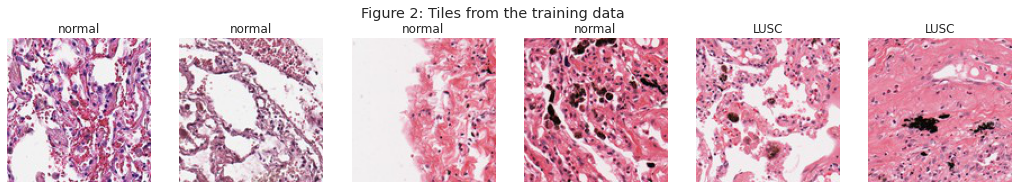

In [176]:
training_data_list = pd.read_csv(os.path.join(input_dir, 'train_norm_luad_lscc.csv'))
labels = {0:'normal', 1:'LUAD', 2:'LUSC'} # internal representation of classes is numeric
fig2, axes = plt.subplots(1,6, figsize=(18,3))
fig2.suptitle('Figure 2: Tiles from the training data')
for i, idx in enumerate([2000*x for x in range(6)]): 
    axes[i].imshow(plt.imread(os.path.join(input_dir, training_data_list['path'][idx])))
    axes[i].set_title(labels[training_data_list['reference_value'][idx]])
    axes[i].axis('off')

Further, we inspect visually how many tiles there are per patient (due to different sizes of slides and amount of slides per patient): 

Total number of tiles: 363,414


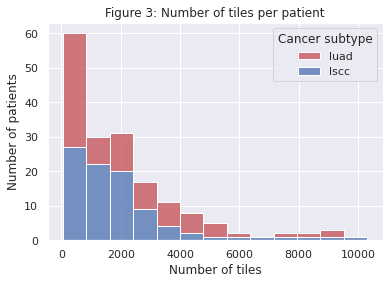

In [177]:
patient_metadata = pd.read_csv(os.path.join(input_dir, 'patient_metadata.csv'))
print('Total number of tiles: {:,}'.format(patient_metadata['nr_tiles_total'].sum()))

fig3 = sns.histplot(data=patient_metadata, x='nr_tiles_total', hue='cancer_subtype', multiple='stack', palette=['r', 'b'])
fig3.set_title('Figure 3: Number of tiles per patient')
fig3.update({'xlabel': 'Number of tiles', 'ylabel': 'Number of patients'})
legend = fig3.get_legend()
legend.set_title('Cancer subtype')

### Training

**Network training**: Following Coudray *et al.*, we use the InceptionV3 network architecture as implemented by Keras and depicted in the image below. The loss function is here defined as categorical cross entropy between the true labels and the network's predictions. RMSprop optimizer is utilized for learning with a learning rate of 0.1, weight decay of 0.9, momentum of 0.9 and epsilon of 1.0. Model checkpoints are automatically saved at each epoch in which the validation loss improves. 

![inceptionV3.png](idc-pathomics/inceptionV3.png)

In [ ]:
from idc_pathomics.data.data_set import Dataset
from idc_pathomics.model.inceptionv3_model import InceptionModel

output_dir_experiment = os.path.join(output_dir, time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(output_dir_experiment)

# Load datasets
dataset_train = Dataset(os.path.join(input_dir, 'train_norm_luad_lscc_20_first200slides_2.csv'), num_classes=3)
dataset_valid = Dataset(os.path.join(input_dir, 'valid_norm_luad_lscc_20_first200slides_2.csv'), num_classes=3)

# Model set-up and training
model = InceptionModel(num_classes=3, input_shape=(128,128,3), learning_rate=0.1)
model.train(dataset_train, batch_size=512, epochs=30, output_path=output_dir_experiment, validation_dataset=dataset_valid) 

Epoch 1/30
24/24 [==============================] - 37s 1s/step - loss: 1.7095 - auc_19: 0.6388 - val_loss: 48597164032.0000 - val_auc_19: 0.5644
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210924_132656/checkpoint_001/assets
Epoch 2/30
24/24 [==============================] - 27s 1s/step - loss: 1.1606 - auc_19: 0.7887 - val_loss: 621847936.0000 - val_auc_19: 0.4624


### Evaluation

The final model is selected as the one with the best (minimal) loss on the validation dataset. The performance of this model is evaluated quantitatively by means of receiver operating characteristic (ROC) curves and observed qualitatively using heatmap visualization. First, the model makes predictions for the entire test set and stores them in the experiment's output directory to make subsequent evaluation easily repeatable. 

**ROC analysis** for each of the three classes (normal, LUAD, LSCC) is performed on **tile-level** (tile-based ROC) and on **slide-level** (slide-based ROC). For slide-level analysis the probabilities for each slide are aggregated either by averaging the probabilities of the corresponding tiles, or by counting the percentage of tiles positively classified. Respective Area under the ROC curve (AUC) values are reported in the table below and the slide-based ROC curves are visualized in Figure 4. In addition to the ROC curves for each class, a micro-average ROC is computed and visualized. 

**Heatmaps** for visually inspecting the network's predictions for some of the slides. The color of each tile corresponds to the class assigned by our model, with the hue indicating how confident the network is in this classification. Hereby a darker hue corresponds to higher confidence. The respective orginal WSI is shown as thumbnail image next to the heatmap. The generation of a thumbnail image takes ~1min, thus we limit ourselves to showing heatmaps for only 4 random slides from the testset. 

In [204]:
# Load the best model 
checkpoints = glob.glob(os.path.join(output_dir_experiment, 'checkpoint*/'))
checkpoints.sort()
best_model_dir = checkpoints[-1] # last checkpoint is the one with the best validation loss 
best_model = InceptionModel.load(best_model_dir)

In [205]:
from idc_pathomics.evaluation.predictions import Predictions

test_dataset = Dataset(os.path.join(input_dir, 'test_norm_luad_lscc_20_first200slides_2.csv'), num_classes=3)
#test_dataset = Dataset('/home/jupyter/idc_input_vm/test_norm_luad_lscc_20_first200slides_2.csv', num_classes=3)

predictions = Predictions(best_model, test_dataset) 
predictions.save(os.path.join(output_dir_experiment, 'predictions_20_first200slides_2.json'))

tile-based AUC     slide-based AUC                    
                      average probability percentage positive
Normal          0.859               0.996               0.992
LUAD            0.889               0.887               0.911
LUSC            0.975               0.920               0.885
Micro           0.888               0.906               0.914

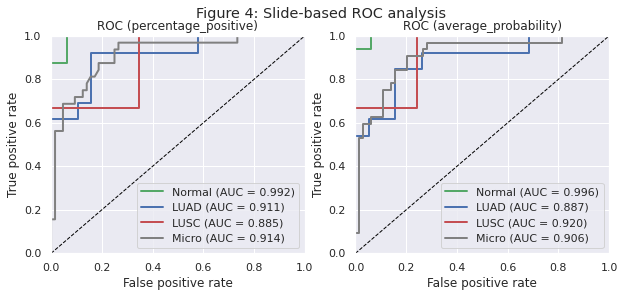

In [206]:
from idc_pathomics.evaluation.roc import ROCAnalysis

roc_analysis = ROCAnalysis(predictions)
roc_analysis.print_and_save_tabluar_results(os.path.join(output_dir_experiment, 'results_table_20_first200slides_2.html'))
roc_analysis.plot_and_save(output_dir_experiment) 

In [43]:
%%capture --no-display
from idc_pathomics.data.utils import get_random_testset_slide_ids, get_thumbnail, get_slide_tissue_type
from idc_pathomics.evaluation.heatmap import get_heatmap, plot_colormap_legend
from idc_pathomics.evaluation.predictions import Predictions

# Select slides and download thumbnails 
heatmap_slide_ids = get_random_testset_slide_ids(slides_metadata)
get_thumbnail(heatmap_slide_ids, slides_metadata_path, slides_dir, google_cloud_project_id=my_project_id) # NOTE: lasts ~1min per slide

# Generate figure 
plot_colormap_legend()
fig5, axes = plt.subplots(4, 2, figsize=(10, 9))
fig5.suptitle('Figure 5: Heatmap visualization')
for i in range(4):
    slide_id = heatmap_slide_ids[i]#'C3L-00913-22'#
    slide = plt.imread(os.path.join(slides_dir, slide_id + '.png'))
    true_tissue_type = get_slide_tissue_type(slide_id, slides_metadata)
    axes[i,0].imshow(get_heatmap(predictions, slide_id))
    axes[i,1].imshow(slide1)
    axes[i,1].set_title(true_tissue_type.upper())
    axes[i,0].axis('off')
    axes[i,1].axis('off')

ValueError: a must be greater than 0 unless no samples are taken